# Tweet sentiment analysis

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import cufflinks as cf
import plotly
import plotly.graph_objs as go
import datetime
import boto3
import s3fs
pd.set_option('display.max_colwidth', -1)
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

## Get dataframe from S3 bucket

In [2]:
bucketname = 'ops-vw-interns-climate-perception-tweets'
dataframe = pd.DataFrame(columns=('creation date','keyword', 'tweet', 
                                  'username'))
s3 = boto3.resource('s3')

s3_tweets = s3.Bucket(bucketname).objects.filter(Prefix='objects/', Delimiter='/').all()
for file in s3_tweets:
    temp_df = pd.read_json('s3://{}/{}'.format(bucketname, file.key))
    dataframe = dataframe.append(temp_df, sort=False, ignore_index=True)
dataframe_tweets = dataframe['tweet']
dataframe.info()

Objects in S3 bucket: 
	tweet-objects/tweets2019-10-10.json
	tweet-objects/tweets2019-10-12.json
	tweet-objects/tweets2019-10-13.json
	tweet-objects/tweets2019-10-14.json
	tweet-objects/tweets2019-10-15.json
	tweet-objects/tweets2019-10-16.json
	tweet-objects/tweets2019-10-17.json
	tweet-objects/tweets2019-10-18.json
	tweet-objects/tweets2019-10-19.json
	tweet-objects/tweets2019-10-20.json
	tweet-objects/tweets2019-10-21.json


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 4 columns):
creation date    12630 non-null object
keyword          12630 non-null object
tweet            12630 non-null object
username         12630 non-null object
dtypes: object(4)
memory usage: 394.8+ KB


## Data cleaning

In [ ]:
pattern = 'climate change|climatechange|global warming|globalwarming'
dataframe = dataframe[dataframe.tweet.str.contains('(?i)'+pattern)]
dataframe.info()

In [3]:
# Preprocessing of tweet texts
def format_tweet(tweet):
    processed_tweet=''
    for word in tweet.split():
        # Removing URL from tweet
        processed_word = re.sub('([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ', word)
        
        # remove all single characters
        processed_word = re.sub('\s+[a-zA-Z]\s+', ' ', processed_word)
        
        # Remove single characters from the start
        processed_word = re.sub('\^[a-zA-Z]\s+', ' ', processed_word) 
        
        # Substituting multiple spaces with single space
        processed_word = re.sub('\s+', '', processed_word, flags=re.I)
        
        # Removing prefixed 'b'
        processed_word = re.sub('^b\s+', ' ', processed_word)
        
        # Removing &amp
        processed_word = re.sub('&amp', '&', processed_word)
        
        # Removing breaks
        processed_word = re.sub('<br/>', '', processed_word)
        
        # converts to lower
        processed_word = processed_word.lower()
        processed_tweet= processed_tweet+' '+processed_word
    return processed_tweet        
    
tweets_text = [format_tweet(tweet) for tweet in dataframe_tweets]
print('unprocessed tweet: \n'+ dataframe['tweet'][15])
print('\nprocessed tweet: \n' + tweets_text[15])

unprocessed tweet: 
AOC: My ‘Dreams of Motherhood Now Bittersweet’ Because of Global Warming https://t.co/uUIM3uSbTi https://t.co/WFLq78IywX

processed tweet: 
 aoc my dreams of motherhood now bittersweet because of global warming  


## Labeling tweets with NLTK vader
Provides te dataframe of the needed 'label' / 'target' column. In our case this column contains the sentiment values (Positive, Neutral, Negative)

In [2]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...


True

In [5]:
sid = SentimentIntensityAnalyzer()

for i, tweet in enumerate(tweets_text[50:60]):
    print('{0}:{1} \n{2}\n\n'.format(i, tweet, sid.polarity_scores(tweet)))

0: climate change evidence how do we know gt vital signs of the planet global climate change and global warming how do we know its happening heres the evidence  
{'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'compound': 0.5994}


1: the election debate is over stay on the track libs mistakes in four years must not be hidden apologized snc lavalin climate change vs pipeline international relations economy down huge deficit list goes on never repeated libs must go say no to libs vote no  
{'neg': 0.219, 'neu': 0.738, 'pos': 0.044, 'compound': -0.8054}


2: revealed google made large contributions to climate change deniers  
{'neg': 0.208, 'neu': 0.792, 'pos': 0.0, 'compound': -0.2732}


3: climate change the devastating effect plastics have on our oceans dwindling numbers of rare species nah  
{'neg': 0.289, 'neu': 0.711, 'pos': 0.0, 'compound': -0.6908}


4: pieces of junk toplevel japanese climate scientist rejects global warming panic  opinion  lifesite  
{'neg': 0.359, 'neu': 0.552, 'pos'

In [6]:
def get_sentiment(polarity):
    if polarity > 0:
        return 'positive'
    if polarity == 0:
        return 'neutral'
    else:
        return 'negative'

word_count = [len(tweet.split()) for tweet in dataframe_tweets]

polarity_tweets = [round(sid.polarity_scores(tweet)['compound'], 2)
                   for tweet in tweets_text]

sentiment_tweets = [get_sentiment(polarity) for polarity in polarity_tweets]

zipped_list = list(zip(sentiment_tweets, polarity_tweets,
                       tweets_text, word_count, dataframe['username'], 
                       dataframe['creation date']))


# Store to new dataframe with sentiment values and polarities
sentiment_df = pd.DataFrame(zipped_list, 
                            columns=['Sentiment', 'Polarity', 
                                     'Tweet', 'Word count', 'Username', 
                                     'Creation Date'])
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 7 columns):
Sentiment        12630 non-null object
Polarity         12630 non-null float64
Tweet            12630 non-null object
Word count       12630 non-null int64
Keyword          12630 non-null object
Username         12630 non-null object
Creation Date    12630 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 690.8+ KB


In [7]:
sentiment_df.sample(15)

,Sentiment,Polarity,Tweet,Word count,Keyword,Username,Creation Date
11456,positive,0.51,bill gates sat down with david rubenstein on the new peer to peer conversations to discuss global warming big tech and why he thinks impossible foods and beyond meat can help the environment apple podcasts spotify,41,Climate change,1e8bdda56b849fd45138ffb756673fea,2019-10-21 20:26:56
8104,negative,-0.78,the fear of climate change will keep aoc from procreating how is that a negative result,16,Climate change,b3e0de21545039c964fc683c71cbb183,2019-10-19 20:12:18
6627,positive,0.13,watch graceandfrankie protest climate change like the cast of graceandfrankie,11,Climate change,c4c092e3488625e6c4d7b5bea403579c,2019-10-18 20:18:53
9920,positive,0.69,so good sending it out in a new form thank you maryheglar,13,Climate change,7eaca03787732c5489f4f72896f03a9f,2019-10-20 19:46:39
4863,positive,0.75,putting a price on carbon can have a largescale impact on climate change half a dozen bills now in congress call for some form of carbon pricing join many others to support this vital national policy,37,Climate change,52755fd063d5d6f80a3d6978e86ebb26,2019-10-17 20:31:00
4322,positive,0.38,icse seis 2020 is now accepting research papers with societal impacts climate change public health cybersecurity or democracy deadlineoct 29 icse20 icseconf,24,Climate change,6c1c37003a87bdd58fa0810ac3559146,2019-10-16 19:31:39
7558,negative,-0.66,anticipated unpopular opinion supporting those being arrested for protesting climate change then 10 mins later tweeting about how the private jet youre on has wifi isnt a good look,29,Climate change,99a7993f81ee1accf1ae51a1d37e2594,2019-10-18 19:10:58
11614,neutral,0.00,why does the arctic region influence climate change worldwide learn more here climatecrisis actonclimatechange,16,Climate change,02927b2fb0a1f5dbb487da291a65a5b3,2019-10-21 20:15:21
4854,positive,0.27,mayor ronnirenberg plans to create a council of youth ambassadors as he recognized that the younger generation are the ones calling to their elected officials for governmental action on climate change,32,Global warming,ecef0f2a3a5f2cdaa0c936259046e5ce,2019-10-17 20:32:07
11396,positive,0.38,we have over 800 military bases why we can save billions by closing some of them lets start with the ones affected by climate change,25,Climate change,47dee0ac8703ba1069780a7e55258af0,2019-10-21 20:31:09


In [8]:
print('5 most negative tweets: \n')
top5_negative = pd.DataFrame(sentiment_df.sort_values('Polarity')[['Tweet','Polarity']].head(5))
top5_negative

5 most negative tweets: 



,Tweet,Polarity
3882,this is literally worse than isis terrorism racism homophobia sexism cancer global warming poverty world hunger israel war drug addiction the prison system police animal abuse pollution murder sexual abuse violence zionism depression mass shootings,-0.99
10416,snap the hell out of it people border crisis not working climate change failing gun confiscation failing oh so lets jump on the period crisis really if you fall for this one and participate in any way you really are a lost brain deadwashed person,-0.98
2328,i think everyone in this country has a short fuse right now due to rump amp the company he keeps i know i seem to get angry mad sad pissed frustrated discouraged and angry some more now talk about climate change since 2016 when rump got put in office i think were all hot,-0.97
4429,doctored photos wild conspiracy theories amp vile abuse if you navigate through social media you will find out the abuse that climate activist gretathunberg has been receiving at the hands of climate change trolls this bullying must stop this report by palkisu tells you more,-0.97
9911,fuck you fuck feelings fuck gender norms fuck global warming fuck the education system fuck discrimination fuck everything,-0.97


In [9]:
print('5 most positive tweets: \n')
top5_positive = sentiment_df.sort_values('Polarity', ascending=False)[['Tweet', 'Polarity']].head(5)
top5_positive

5 most positive tweets: 



,Tweet,Polarity
8334,dear greta i want to thank you and your family for coming to canada to encourage climate activism and radical change you have made a huge difference and given people like me hope thank you amp blessings,0.97
3936,i rarely pay attention to will but he wears a sherwani well kate has also looked quite lovely in her outfits by designers i am so glad they are trying to highlight the effects of climate change with their visit and hope both brothers continue using their platforms to do so,0.97
1884,great visit this pm to centrealttech in machynlleth to meet their management team and listen to their exciting and ambitious plans for the future impressive increase in both visitor and student numbers this year hopefully a sign of more interest in climate change perhaps,0.97
10092,challenge to provide reliability to a growing population while addressing climate change that which makes us distinctive intellect and true love share many of the same qualities indestructible pure and beautiful to,0.96
12200,god of creation we pray for solutions to urgent environmental concerns such as global warming diminishing resources and pollution merciful lord please prompt rich government corporations and the wealthy to fund initiatives that can protect our worldamen careforni,0.96


## Data visualisation

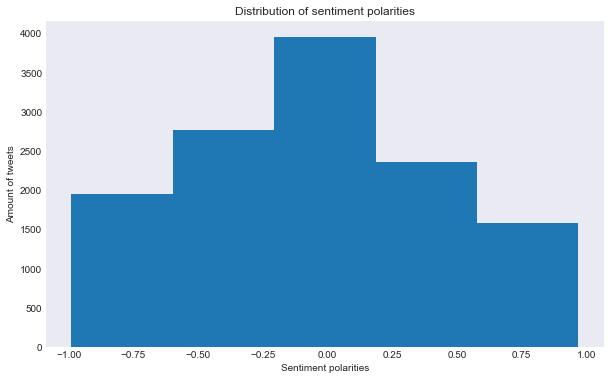

In [11]:
sentiment_df['Sentiment'].iplot(
    kind='hist',
    linecolor='black',
    theme='ggplot',
    xTitle='Sentiment',
    yTitle='count',
    title='Class distribution')

Total tweets with climate change keyword: 10908
Total tweets with global warming keyword: 1634
Total tweets with Global warming & Climate change as keyword: 88


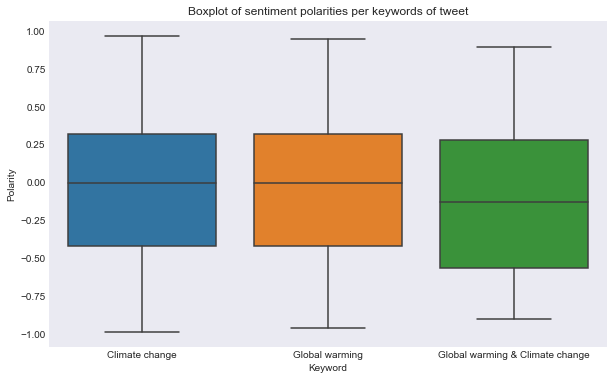

In [12]:
sentiment_df['Polarity'].iplot(
    kind='hist',
    bins=75,
    linecolor='black',
    theme='ggplot',
    xTitle='polarity',
    yTitle='count',
    title='Sentiment Polarity Distribution')
plt.show()

In [ ]:
sentiment_df['Word count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    colors='blue',
    theme="ggplot",
    yTitle='count',
    title='Tweet text word count distribution')

In [ ]:
import wordcloud
# Joins all tweets to one string:
text = ' '.join(tweet for tweet in sentiment_df[sentiment_df['Sentiment']=='negative']['Tweet'])

# Create and generate a word cloud image:
wordcloud = wordcloud.WordCloud(background_color="white", width=1600, height=800).generate(text)

# Display the generated image:

plt.figure(figsize=[15,10])
plt.title('Most used words in negative tweets')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
import wordcloud
# Joins all tweets to one string:
text = ' '.join(tweet for tweet in sentiment_df[sentiment_df['Sentiment']=='positive']['Tweet'])

# Create and generate a word cloud image:
wordcloud = wordcloud.WordCloud(background_color="white", width=1600, height=800).generate(text)

# Display the generated image:
plt.figure(figsize=[15,10])
plt.title('Most used words in positive tweets')
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Implementing machine learning classifiers

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import PorterStemmer
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ROCAUC
from yellowbrick.target import ClassBalance
from yellowbrick.features.pca import PCADecomposition

ModuleNotFoundError: No module named 'yellowbrick'

### Divide into training and test sets
We create our feature and label sets for training and testing using sklearn's train_test_split. 80% of the data will go to training sets and 20% will go to the testing sets. The method shuffles the data in a random order to make sure the sets are not unbalanced.

In [14]:
from sklearn.model_selection import train_test_split

# Extract features from df
features = sentiment_df['Tweet']

# Extract labels from df
labels = sentiment_df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(features,
                                                    labels, test_size=0.2,
                                                    random_state=1)

print('Training set contains: '+str(len(X_train))+ ' samples')
print('Testing set contains: '+str(len(X_test))+ ' samples')

Training set contains: 10104 samples
Testing set contains: 2526 samples


### Preparing pipeline variables
Setup of tokenizers (converting 1 text object to a list of text objects)
and vectorizers

In [16]:
count_vec = CountVectorizer(strip_accents=None, lowercase=False, 
                            preprocessor = None)
tfidf = TfidfTransformer()

def tokenizer(text):
    return text.split()

porter = PorterStemmer()
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

#### Testing tokenizers

In [17]:
sample_tweet = tweets_text[455]

token_list = tokenizer(sample_tweet)

porter_list =tokenizer_porter(sample_tweet)
print(sample_tweet)

In [18]:
count_vec.fit(token_list)
print('With normal tokenizer:')
count_vec.vocabulary_

With normal tokenizer:


{'Hi': 0,
 'think': 6,
 'global': 4,
 'warming': 7,
 'is': 5,
 'awesome': 3,
 'What': 1,
 'about': 2,
 'you': 8}

In [19]:
count_vec.fit(porter_list)
print('With porter tokenizer (stemmer):')
count_vec.vocabulary_

With porter tokenizer (stemmer):


{'Hi': 0,
 'think': 5,
 'global': 3,
 'warm': 6,
 'is': 4,
 'awesome': 2,
 'what': 7,
 'about': 1,
 'you': 8}

### Implementing logistic regression classifier

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
import warnings
warnings.filterwarnings('ignore')

lr_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', LogisticRegression(random_state=1))])

lr_param_grid ={
                'vect__ngram_range': [(1,1),(1,2)],
                'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],
    
                'clf__dual': [True, False],
                'clf__tol': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2 ],
                'clf__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                'clf__fit_intercept': [True, False],
                'clf__max_iter' : [100, 110, 120, 130, 140],
                'clf__warm_start': [True, False]
              }
lr_grid = RandomizedSearchCV(lr_pipeline, lr_param_grid, n_iter=10,
                             verbose=10, cv=5, n_jobs=-1, scoring='accuracy')
lr_grid.fit(X_train, y_train)
print()

Fitting 9 folds for each of 80 candidates, totalling 720 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.7min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  8.0min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 14.9min
[Parallel(n_jobs=2)]: Done 720 out of 720 | elapsed: 26.1min finished


In [22]:
print('Best parameters: ', grid_lr.best_params_)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_lr.best_score_*100))

lr_results = pd.DataFrame.from_dict(lr_grid.cv_results_)

pd.set_option('display.max_colwidth', 50)

lr_results

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x0000025320CCC6A8>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': False, 'tfidf__norm': 'l2', 'clf__fit_prior': False, 'clf__alpha': 0.1}

The Multinomial Naive Bayes classifier has reached an accuracy of: 74.51% 



In [ ]:
lr_results['std_fit_time'].iplot(
    kind='scatter',
    xTitle='',
    linecolor='black',
    colors='blue',
    theme="ggplot",
    yTitle='count',
    title='')

### Implementing Multinomial Naive Bayes
Based on Bayes theorem. Predicts the probability of an output based on combination of given input parameters

In [23]:
from sklearn.naive_bayes import MultinomialNB

In [24]:
mnb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                         ('clf', MultinomialNB())])

mnb_param_grid = {
                  'vect__ngram_range': [(1,1), (1,2), (1,3)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],
    
                  'clf__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                  'clf__fit_prior': [True, False]
                 }
mnb_grid = RandomizedSearchCV(mnb_pipeline, mnb_param_grid, n_iter=50,
                              cv=5, verbose=10, n_jobs=-1, scoring='accuracy')
mnb_grid.fit(X_train, y_train)
print()

Fitting 7 folds for each of 150 candidates, totalling 1050 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  1.9min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:  8.3min
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed: 17.7min
[Parallel(n_jobs=2)]: Done 796 tasks      | elapsed: 27.0min
[Parallel(n_jobs=2)]: Done 1050 out of 1050 | elapsed: 36.3min finished


In [25]:
print('Best parameters: ', grid_mnb.best_params_)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(grid_mnb.best_score_*100))

mnb_results = pd.DataFrame.from_dict(grid_mnb.cv_results_)

pd.set_option('display.max_colwidth', 50)

mnb_results

Best parameters:  {'vect__tokenizer': <function tokenizer_porter at 0x0000025320CCC6A8>, 'vect__ngram_range': (1, 1), 'tfidf__use_idf': True, 'tfidf__norm': 'l2', 'clf__warm_start': True, 'clf__tol': 0.001, 'clf__max_iter': 100, 'clf__fit_intercept': True, 'clf__dual': True, 'clf__C': 10}

The Logistic Regression classifier has reached an accuracy of: 80.80% 



### Implementing Support Vector Machine

In [26]:
from sklearn.svm import SVC

In [ ]:
svc_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', SVC(random_state=1))])

svc_param_grid = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__C': [0.1, 1, 10, 100],
                  'clf__kernel': ['linear', 'rbf', 'poly'],
                  'clf__gamma': [0.1, 1, 10, 100],
                  'clf__degree': [0, 1, 2, 3, 4, 5, 6]
                 }

svc_grid = RandomizedSearchCV(svc_pipeline, svc_param_grid, n_iter=80, 
                              cv=7, verbose=1, n_jobs=2, scoring='accuracy')
svc_grid.fit(X_train, y_train)
print()

Fitting 7 folds for each of 80 candidates, totalling 560 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 18.6min
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 72.2min


In [ ]:
print('Best parameters: ', grid_svc.best_params_)
#Create classifier based on best parameters

print('\nThe Support Vector classifier has reached an accuracy of: {:.2f}% \n'
      .format(svc_grid.best_score_*100))

svc_results = pd.DataFrame.from_dict(svc_grid.cv_results_)

pd.set_option('display.max_colwidth', 50)
svc_results

### Implementing decision tree
Tries to determin the class/label of a datapoint based on sequential conditions

In [ ]:
from sklearn import tree

In [ ]:
dt_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', tree.DecisionTreeClassifier(random_state=1))])

dt_param_grid = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__max_depth': np.arange(1, 100),
                  'clf__max_features': np.arange(1, 50),
                  'clf__min_samples_leaf': np.arange(1, 50),
                  'clf__criterion':['gini','entropy']
                 }

dt_grid = RandomizedSearchCV(dt_pipeline, dt_param_grid, n_iter=50, 
                              cv=5, verbose=1, n_jobs=-1, scoring='accuracy')
dt_grid.fit(X_train, y_train)
print()

In [ ]:
print('Best parameters: ', dt_grid.best_params_)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(dt_grid.best_score_*100))

dt_results = pd.DataFrame.from_dict(dt_grid.cv_results_)

pd.set_option('display.max_colwidth', 50)

dt_results

### Implementing Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rf_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf), 
                        ('clf', RandomForestClassifier(random_state=1))])

rf_param_grid = {
                 'vect__ngram_range': [(1,1),(1,2), (1,3)],
                 'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                 'tfidf__use_idf': [True, False],
                 'tfidf__norm': ['l1', 'l2'],                  
    
                 'clf__n_estimators': [500, 750, 1000, 1500],
                 'clf__max_features': ['auto', 'sqrt'],
                 'clf__max_depth': np.linspace(1, 64, 32, endpoint=True),
                 'clf__min_samples_split': [2, 5, 10],
                 'clf__min_samples_leaf': [1, 2, 4],
                 'clf__bootstrap': [True, False]
                }

rf_grid = RandomizedSearchCV(rf_pipeline, rf_param_grid,
                             cv=7, n_iter=100 , verbose=1, n_jobs=2, 
                             scoring='accuracy')

rf_grid.fit(X_train, y_train)
print()

In [ ]:
print('Best parameters: ', rf_grid.best_params_)

print('\nThe Logistic Regression classifier has reached an accuracy of: {:.2f}% \n'
      .format(rf_grid.best_score_*100))

rf_results = pd.DataFrame.from_dict(rf_grid.cv_results_)

pd.set_option('display.max_colwidth', 50)

rf_results

### Testing XGBoost (extreme gradient boosting)

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance.
Very popular

In [ ]:
import xgboost

In [ ]:
xgb_pipeline = Pipeline([('vect', count_vec), ('tfidf', tfidf),
                         ('clf', xgboost.XGBClassifier())])

param_grid_xgb_param_grid = {
                  'vect__ngram_range': [(1,1),(1,2)],
                  'vect__tokenizer': [tokenizer, tokenizer_porter],
    
                  'tfidf__use_idf': [True, False],
                  'tfidf__norm': ['l1', 'l2'],                  
    
                  'clf__learning_rate'    : [0.005, 0.01, 0.05, 0.10, 0.15, 0.20] ,
                  # Defines how many different features are used in each tree
                  'clf__max_depth'        : [ 3, 4, 5, 6, 8, 10, 12, 15],
                  'clf__min_child_weight' : [ 1, 3, 5, 7 ],
                  'clf__gamma'            : [ 0, 0.01, 1, 5 ],
                  'clf__colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
                  'clf__n_estimators'     : [ 10, 100, 1000]
                 }

xgb_grid = RandomizedSearchCV(xgb_pipeline,xgb_param_grid, n_iter=4, 
                              cv=2, verbose=5, n_jobs=-1, scoring='accuracy')
xgb_grid.fit(X_train, y_train)
print()

In [ ]:
print('Best parameters chosen by grid search: \n'+str(xgb_grid.best_params_))
#Create classifier based on best parameters
print('\nThe XGBoost  classifier has reached an accuracy of: {:.2f}% \n'
       .format(xgb_grid.best_score_*100))

xgb_results = pd.DataFrame.from_dict(xgb_grid.cv_results_)

pd.set_option('display.max_colwidth', 50)

xgb_results

## Comparing clasiffier results

### Confusion matrices
Matrix that shows the true and false predictions per class

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ConfusionMatrix(model=mnb, classes=classes, ax=ax[0,0]),
    ConfusionMatrix(model=lr, classes=classes, ax=ax[0,1]),
    ConfusionMatrix(model=svm, classes=classes, ax=ax[1,0]),
    ConfusionMatrix(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    viz.finalize()


### ROCAUC curve
tradeoff between the model’s sensitivity and specificity

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,15), tight_layout=True)

visualgrid = [
    ROCAUC(model=mnb, classes=classes, ax=ax[0,0], micro=False, macro=False),
    ROCAUC(model=lr, classes=classes, ax=ax[0,1], micro=False, macro=False),
    ROCAUC(model=svm, classes=classes, ax=ax[1,0], micro=False, macro=False),
    ROCAUC(model=rf, classes=classes, ax=ax[1,1], micro=False, macro=False)
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()


### Classification reports
Report on the accuracy of the classifier

In [ ]:
fig, ax = plt.subplots(2,2, figsize=(15,8), tight_layout=True)

visualgrid = [
    ClassificationReport(model=mnb, classes=classes, ax=ax[0,0]),
    ClassificationReport(model=lr, classes=classes, ax=ax[0,1]),
    ClassificationReport(model=svm, classes=classes, ax=ax[1,0]),
    ClassificationReport(model=rf, classes=classes, ax=ax[1,1])
]

for viz in visualgrid:
    viz.fit(X_train, y_train)
    viz.score(X_test, y_test)
    for label in viz.ax.texts:
        label.set_size(15)
    viz.finalize()
